In [8]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import utilities as ut
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


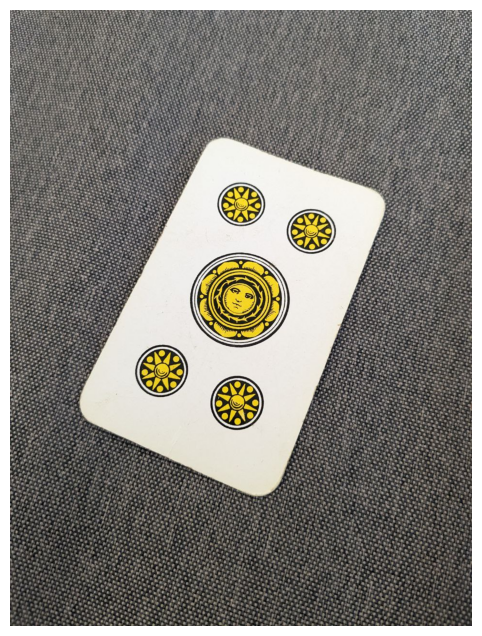

In [9]:
img = cv2.imread('Images/card.jpg')
ut.print_image(img,type="bgr")


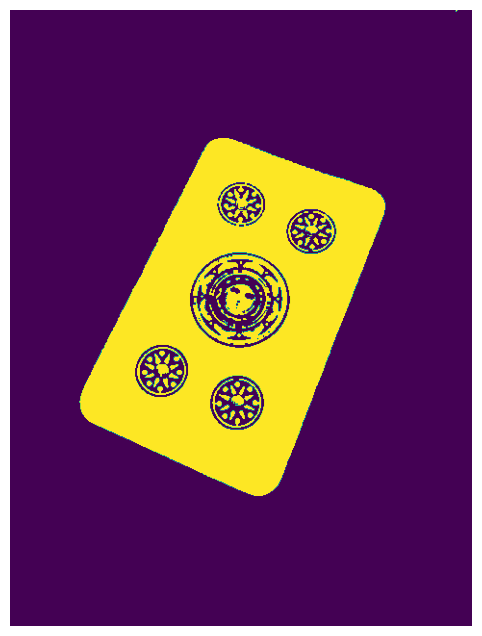

In [10]:

def downsampler(image, ratio):
    #The camera used for the images generates photo with a too high of a definition.
    #This Generates contours on little imperfections of the card or the background. 
    imx=int(image.shape[0]/ratio)
    imy=int(image.shape[1]/ratio)
    return cv2.resize(image, (imy,imx), interpolation= cv2.INTER_LINEAR)

down_sampled = downsampler(img,2)
#To help with the processing, was decided to smooth the morphology of the image, making the background more uniform.
kernel = np.ones((5,5),np.uint8)
uniformed_image = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations= 3)
#For the explanation of the preprocessing refer to the file preprocessing_exp.ipynb
#the invert binary flag is applied since we want to identify a white object on a dark background
#while the normal preprocessing is applied to the cards figure
binary_image,contours = ut.preprocess_image(down_sampled,invert_binary=False)
image= down_sampled
ut.print_image(binary_image)

In [11]:
## only draw contour that have big areas
imx = img.shape[0]
imy = img.shape[1]
lp_area = (imx * imy) / 150
print(lp_area)

8192.0


In [12]:
def order_points(pts):
    # Initialize a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # Computing the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # Return the ordered coordinates
    return rect


In [13]:
def four_point_transform(image, pts):
    # Obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    # Compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordinates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # Compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # Now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # Compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # Return the warped image
    return warped

4


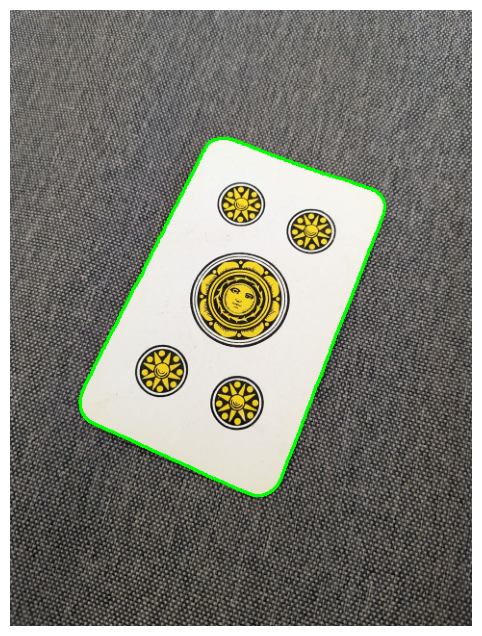

In [14]:
## Get only rectangles given exceeding area
found= False
for cnt in sorted(contours, key=cv2.contourArea, reverse=True):
    approx = cv2.approxPolyDP(cnt,0.1 * cv2.arcLength(cnt, True), True)
    ## Calculate number of vertices
    print(len(approx))

    if len(approx) == 4 and cv2.contourArea(cnt) > lp_area:
        found = True
        card_contour = cnt;
        tmp_image = image.copy()
        cv2.drawContours(tmp_image, [card_contour],-1,(0,255,0),2)
        ut.print_image(tmp_image,type="bgr")
        break
if (not found):
    raise RuntimeError("No card found")

Corner Points:  (72, 406) (389, 207) (216, 133) (253, 504)


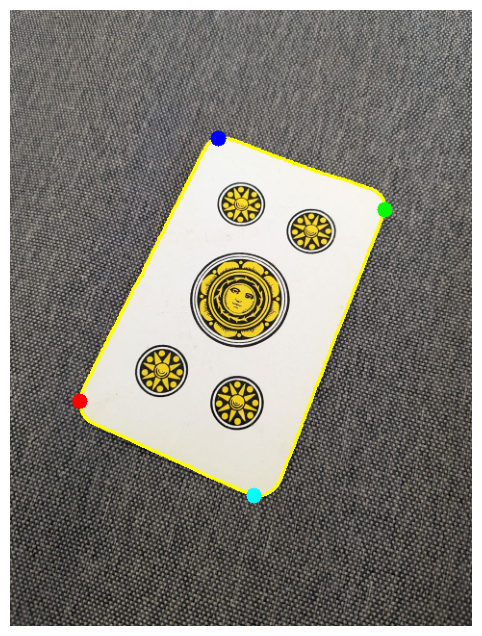

In [15]:

# determine the most extreme points along the contour
# https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/
card_contour = image.copy()
extLeft = tuple(cnt[cnt[:, :, 0].argmin()][0])
extRight = tuple(cnt[cnt[:, :, 0].argmax()][0])
extTop = tuple(cnt[cnt[:, :, 1].argmin()][0])
extBot = tuple(cnt[cnt[:, :, 1].argmax()][0])
cv2.drawContours(card_contour, [cnt], -1, (0, 255, 255), 2)
cv2.circle(card_contour, extLeft, 8, (0, 0, 255), -1)
cv2.circle(card_contour, extRight, 8, (0, 255, 0), -1)
cv2.circle(card_contour, extTop, 8, (255, 0, 0), -1)
cv2.circle(card_contour, extBot, 8, (255, 255, 0), -1)


print("Corner Points: ", extLeft, extRight, extTop, extBot)
ut.print_image(card_contour,type="bgr")

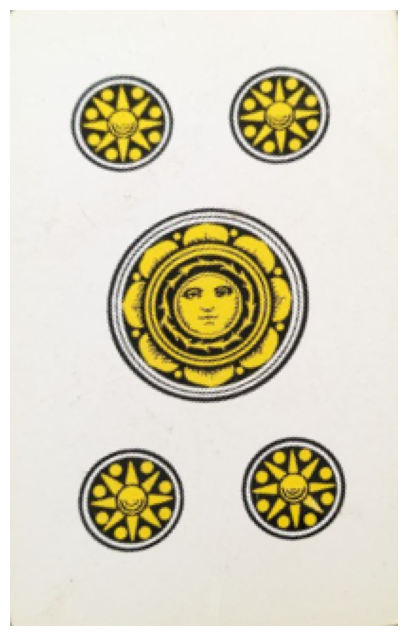

In [16]:
## Perspective Transform
card_contour = image.copy()
pts = np.array([extLeft, extRight, extTop, extBot])
warped = four_point_transform(card_contour, pts)
ut.print_image(warped,type="bgr")

In [17]:
import joblib
clf = joblib.load(ut.Config.working_directory+"forest_classifier.sav")
scaler = joblib.load(ut.Config.working_directory+"scaler.sav")

In [18]:

binary_image,contours_test = ut.preprocess_image(warped)
hue = ut.average_hue_of_contours(warped, [contours_test[0]])
moments = cv2.moments(contours_test[0])
hu_moments_test= cv2.HuMoments(moments).flatten()
data = hu_moments_test.copy()
data = np.append(data,hue)
print(data)
data=scaler.transform(data.reshape(1, -1))
result=clf.predict(data)
print(result)

[ 1.59352732e-01  5.83550600e-05  1.46757090e-07  7.82843152e-11
 -1.33946820e-19 -3.19800843e-13  2.29055601e-19  2.82035316e+01]
['O']


In [19]:
counter=0
if result in ['O','B','S','C']:
    counter=1
    for contour in contours_test[1:7]:
        print(counter)
        moments = cv2.moments(contour)
        hu_moments_test= cv2.HuMoments(moments).flatten()
        hue = ut.average_hue_of_contours(warped, [contour])
        data = hu_moments_test.copy()
        data = np.append(data,hue)
        data=scaler.transform(data.reshape(1, -1))
        if clf.predict(data)== result:
            counter+=1
        else: break    
if(counter==0):
    counter=''

print("{}{}".format(counter,result))

1
2
3
4
5['O']
